# Rule-Based Classification for Donor Age Prediction





## Loading and Cleaning Rules
Load rules from file, remove duplicates, and eliminate rules that are strict subsets of others.


In [10]:
# === Rule Evaluation and Visualization Pipeline ===
# Author: Jan Wilgosz
# Description: Full pipeline for rule deduplication, evaluation, metric computation and visualization.

import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Set, Tuple
import numpy as np

# === Rule processing functions ===
def parse_rule(line: str) -> Set[str]:
    """
    Parses a rule line into a set of predicates.
    Example: "A AND NOT B => donor_is_old" → {"A", "NOT B"}
    """
    lhs, _ = line.strip().split("=>")
    parts = lhs.strip().split("AND")
    return frozenset(part.strip() for part in parts)

def load_rules(file_path: str) -> List[Set[str]]:
    """Loads and parses rules from a file."""
    with open(file_path, 'r') as f:
        return [parse_rule(line) for line in f if line.strip()]

def deduplicate_rules(rules: List[Set[str]]) -> List[Set[str]]:
    """Removes duplicate rules."""
    return list(set(rules))

def remove_redundant_rules(rules: List[Set[str]]) -> List[Set[str]]:
    """Removes rules that are strict subsets of other rules."""
    cleaned = []
    for rule in rules:
        if not any((rule < other) for other in rules):
            cleaned.append(rule)
    return cleaned

# === Load and process rules ===
rules = load_rules("rules.txt")
print(f"[INFO] Number of loaded rules: {len(rules)}")

# === Deduplicate and clean rules ===
rules = deduplicate_rules(rules)
rules = remove_redundant_rules(rules)
print(f"[INFO] Number of cleaned rules: {len(rules)}")


[INFO] Number of loaded rules: 51
[INFO] Number of cleaned rules: 35


## Evaluating Rule-Based Classifier by Sorting Strategy
Compare the performance (precision, recall, F1) of classifiers based on the number of used rules and the strategy for selecting them (sorted by precision, recall, or F1).



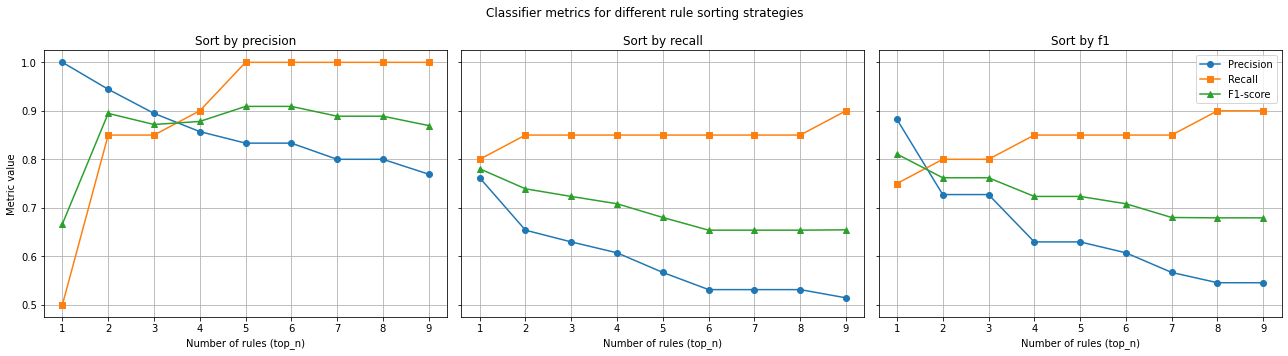


[RESULT] Best configuration: sorted by 'precision', top_n = 5
Selected rules:
 - GDF_15 => donor_is_old
 - NOT HCT AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 - SOST => donor_is_old
 - Neutrophils => donor_is_old
 - NOT Hb AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old

[RESULT] Evaluation metrics for the best configuration:
Precision: 0.8333
Recall: 1.0000
F1-score: 0.9091


In [11]:
# === Rule evaluation ===
def match_rule(rule: Set[str], row: pd.Series) -> bool:
    """
    Checks whether a rule matches a given row in the dataset.
    A rule matches if all its predicates are satisfied in the row.
    """
    for pred in rule:
        is_negated = pred.startswith("NOT ")
        prefix = "NOT "
        col = pred[len(prefix):] if is_negated else pred

        val = row.get(col, pd.NA)
        if pd.isna(val):
            return False
        if is_negated and val:
            return False
        if not is_negated and not val:
            return False
    return True

def evaluate_rules(rules: List[Set[str]], data: pd.DataFrame) -> List[Tuple[Set[str], int, int, int, float, float, float]]:
    results = []
    total_positives = data['donor_is_old'].sum()

    for rule in rules:
        # Apply rule: returns True, False or None
        evals = data.apply(lambda row: match_rule(rule, row), axis=1)

        # Only rows where rule could be evaluated (not None)
        mask_valid = evals.notna()
        mask_matched = evals == True
        valid_rows = data[mask_valid]
        matched_rows = data[mask_matched]

        coverage = len(matched_rows)
        true_positives = matched_rows['donor_is_old'].sum()
        false_positives = coverage - true_positives

        precision = true_positives / coverage if coverage > 0 else 0
        recall = true_positives / total_positives if total_positives > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        results.append((rule, coverage, true_positives, false_positives, precision, recall, f1))
    return results

# === Load dataset ===
data = pd.read_csv("dataset.tsv", sep='\t')
results = evaluate_rules(rules, data)

# === Evaluate rule sets ===
eval_rows = []
all_sorted = {}

for sort_by, idx in [('precision', 4), ('recall', 5), ('f1', 6)]:
    sorted_results = sorted(results, key=lambda x: -x[idx])
    all_sorted[sort_by] = sorted_results

    for top_n in range(1, 10):
        top_rules = [r[0] for r in sorted_results[:top_n]]
        y_true = data['donor_is_old']
        y_pred = data.apply(lambda row: any(match_rule(rule, row) for rule in top_rules), axis=1)

        tp = (y_true & y_pred).sum()
        prec = tp / y_pred.sum() if y_pred.sum() > 0 else 0
        rec = tp / y_true.sum() if y_true.sum() > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

        eval_rows.append({'sort_by': sort_by, 'top_n': top_n, 'precision': prec, 'recall': rec, 'f1': f1})

# Create evaluation dataframe (no CSV save)
eval_df = pd.DataFrame(eval_rows)

# Plot metrics for different rule sortings (side-by-side)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, metric in enumerate(['precision', 'recall', 'f1']):
    subset = eval_df[eval_df['sort_by'] == metric]
    axes[i].plot(subset['top_n'], subset['precision'], label="Precision", marker='o')
    axes[i].plot(subset['top_n'], subset['recall'], label="Recall", marker='s')
    axes[i].plot(subset['top_n'], subset['f1'], label="F1-score", marker='^')
    axes[i].set_title(f"Sort by {metric}")
    axes[i].set_xlabel("Number of rules (top_n)")
    axes[i].grid(True)
    if i == 0:
        axes[i].set_ylabel("Metric value")
    if i == 2:
        axes[i].legend()

plt.suptitle("Classifier metrics for different rule sorting strategies")
plt.tight_layout()
plt.show()

# Print final selected rules from best configuration
best_row = eval_df.sort_values(by="f1", ascending=False).iloc[0]
best_sort = best_row['sort_by']
best_top_n = int(best_row['top_n'])
best_rules = [r[0] for r in all_sorted[best_sort][:best_top_n]]

print(f"\n[RESULT] Best configuration: sorted by '{best_sort}', top_n = {best_top_n}")
print("Selected rules:")
for rule in best_rules:
    print(" - " + " AND ".join(sorted(rule)) + " => donor_is_old")

print(f"\n[RESULT] Evaluation metrics for the best configuration:")
best_metrics = eval_df[(eval_df['sort_by'] == best_sort) & (eval_df['top_n'] == best_top_n)].iloc[0]
print(f"Precision: {best_metrics['precision']:.4f}")
print(f"Recall: {best_metrics['recall']:.4f}")  
print(f"F1-score: {best_metrics['f1']:.4f}")


## Logistic Regression Using Rule-Based Features
Train a logistic regression model where each rule is a binary feature (0/1). The model learns which rules are most influential in predicting the target class.




[INFO] Running logistic regression on rule-based features...

Top rules selected by logistic regression:
GDF_15 => donor_is_old; coef=1.7328
NOT Hb AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old; coef=1.3319
OMD => donor_is_old; coef=0.4565
NOT Lymphocytes_percent AND NOT Notch_1 => donor_is_old; coef=0.4483
SOST => donor_is_old; coef=0.3053
Neutrophils => donor_is_old; coef=0.2965
Monocytes AND NOT sCD86 => donor_is_old; coef=0.0505
NOT Basophils_percent AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old; coef=0.0205
IL_8 => donor_is_old; coef=0.0196


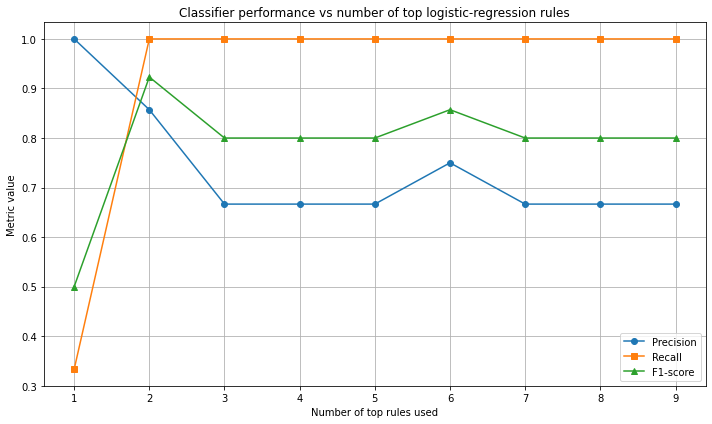


[RESULT] Best configuration: top_n = 2
Selected rules:
 - GDF_15 => donor_is_old
 - NOT Hb AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old

[RESULT] Evaluation metrics for the best configuration:
Precision: 0.8571
Recall:    1.0000
F1-score:  0.9231


In [12]:
# === Logistic Regression using rule-matching as features ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

print("\n[INFO] Running logistic regression on rule-based features...")

# Create binary matrix (rows = samples, cols = rules)
X = []
for idx, row in data.iterrows():
    row_features = []
    for rule in rules:
        result = match_rule(rule, row)
        row_features.append(int(result) if result is not None else 0)
    X.append(row_features)

X = np.array(X)
y = data['donor_is_old'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train full logistic regression
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

# Get coefficients and match with rule names
coefficients = model.coef_[0]
non_zero_indices = np.where(coefficients != 0)[0]
non_zero_coefs = coefficients[non_zero_indices]
non_zero_rules = [" AND ".join(sorted(rules[i])) for i in non_zero_indices]

# Sort by absolute importance
sorted_pairs = sorted(zip(non_zero_rules, non_zero_coefs, non_zero_indices), key=lambda x: -abs(x[1]))
sorted_rules, sorted_coefs, sorted_rule_idxs = zip(*sorted_pairs)

# === Evaluate model performance with incremental top-N rules ===
eval_results = []

for top_n in range(1, len(sorted_rule_idxs) + 1):
    selected_idxs = sorted_rule_idxs[:top_n]
    X_train_sub = X_train[:, selected_idxs]
    X_test_sub = X_test[:, selected_idxs]

    sub_model = LogisticRegression(penalty='none', solver='lbfgs')
    sub_model.fit(X_train_sub, y_train)
    y_pred_sub = sub_model.predict(X_test_sub)

    p = precision_score(y_test, y_pred_sub)
    r = recall_score(y_test, y_pred_sub)
    f1 = f1_score(y_test, y_pred_sub)

    eval_results.append((top_n, p, r, f1))

# Convert to DataFrame
metrics_df = pd.DataFrame(eval_results, columns=['top_n_rules', 'precision', 'recall', 'f1'])

# === Final output: print sorted rules with coefficients ===
print("\nTop rules selected by logistic regression:")
for rule, coef in zip(sorted_rules, sorted_coefs):
    print(f"{rule} => donor_is_old; coef={coef:.4f}")

# Plot performance vs number of rules
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['top_n_rules'], metrics_df['precision'], label='Precision', marker='o')
plt.plot(metrics_df['top_n_rules'], metrics_df['recall'], label='Recall', marker='s')
plt.plot(metrics_df['top_n_rules'], metrics_df['f1'], label='F1-score', marker='^')
plt.xlabel("Number of top rules used")
plt.ylabel("Metric value")
plt.title("Classifier performance vs number of top logistic-regression rules")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n[RESULT] Best configuration: top_n = 2")
print("Selected rules:")
for rule in sorted_rules[0:2]:
    print(f" - {rule} => donor_is_old")

print(f"\n[RESULT] Evaluation metrics for the best configuration:")
row = metrics_df.loc[metrics_df['top_n_rules'] == 2].iloc[0]
print(f"Precision: {row['precision']:.4f}")
print(f"Recall:    {row['recall']:.4f}")
print(f"F1-score:  {row['f1']:.4f}")



## Results

| Method               | Top-N Rules | Precision | Recall | F1-score |
|----------------------|-------------|-----------|--------|----------|
| Top-N Heuristic      | 5           | 0.8333    | 1.0000 | 0.9091   |
| Logistic Regression  | 2           | 0.8571    | 1.0000 | 0.9231   |

Both methods achieve perfect recall, but logistic regression slightly outperforms the heuristic approach in terms of precision and F1-score, using fewer rules.